As every year since 2015, I'm signed up to participate in the qualifications round of [Google Hashcode](https://hashcode.withgoogle.com), a programming competition for students and professionals from Europe, the Middle-East and Africa. While trying to prepare for the competition, I tackled the suggested training problem that aims at cutting pizza slices out of a large pizza. 

In this post, I'll try to outline a solution to the problem based on one of the input files, the `medium.in` input. Along the way, I plan to report on the following topics:

- visualizing your data
- formulating the problem as a greedy optimization task
- knowing your data structures 
- profiling your code
- using Pythran to optimize your code execution time


Let's get started.

# Visualizing your data 

The large pizza we will use as input consists of Tomatoes as well as Mushrooms, which is encode in a grid like the following: 

```
TTTTT
TMMMT
TTTTT
```

Let's load the data for our example grid:

In [1]:
import numpy as np

In [2]:
def read_input_pizza(filename):
    """Reads the input of a Pizza problem.

    returns:

    R: number of Rows of pizza grid
    C: number of Cols of pizza grid
    L: Lowest number of each ingredients per slice
    H: Highest number of cells per slice
    pizza: the pizza grid (1 == tomato, 0 == mushroom)
    """
    lines = open(filename).readlines()
    R, C, L, H = [int(val) for val in lines[0].split()]
    pizza = np.array([list(map(lambda item: 1 if item == 'T' else 0, row.strip())) for row in lines[1:]])
    return R, C, L, H, pizza

In [3]:
R, C, L, H, pizza = read_input_pizza('medium.in')

Let's also plot the pizza:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

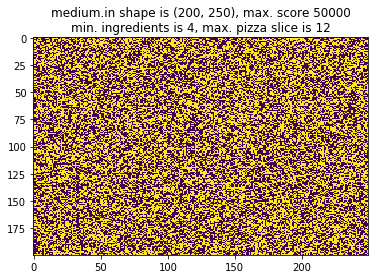

In [5]:
fig, ax = plt.subplots()
ax.imshow(pizza, aspect='auto')
ax.set_title(f'medium.in shape is {pizza.shape}, max. score {pizza.size}\nmin. ingredients is {L}, max. pizza slice is {H}');

As you can read in the above plot, the pizza has a 200 by 250 shape, will need slices that have each at least 4 tomatoes and 4 mushrooms on it and a maximum size of 12 cells. Also, as far as I can tell from that plot, the pizza is made of evenly distributed ingredients.

Let's now try to come up with an algorithm.

# A greedy optimization approach 

While brainstorming  this problem with a friend, we came up with a greedy approach for solving the problem. It can be described by the following Python pseudo-code:

```python
slices = []

while True:
    # randomly choose an available location for the start of the slice
    location = get_random_available_location(pizza)

    # determine possible slice shapes that fit the selected location
    possible_slices = []
    for slice_shape in slice_shapes: 
        if satisfy_constraints(location, slice_shape, pizza):
            possible_slices.append(slice_shape)

    # if we found any possible slices, we take the one with the biggest score
    if len(possible_slices) > 0:
        this_slice = max(possible_slices, key=lambda slice: score(slices + [slice]))
        slices.append(this_slice)
    
        # since we sliced the pizza, we need to update the available cells 
        update_pizza(pizza, this_slice)            
    
    # should we exit while loop?
    if no_more_possible_slices():
        break
   
```

The way the problem is described above has two properties:

- it is greedy (we perform the slicing with the maximum score)
- it is an optimization problem (since we loop over possible slice shapes for each location)

I believe this is generally a good way to solve the problems that come up at Hashcode competitions, thinking about past editions...

# A first version 

With that being said, we can transform the pseudo-code into real code. Below is my first version.

Note that:

- the possible shapes are hard-coded
- we only try one of the possible shapes at the location and move on if it doesn't work

In [6]:
import tqdm
from random import randint

def get_random_available_location(slice_mask):
    """Returns a randomly selected empty location on the slice mask."""
    nonzero_elements = np.nonzero(1 - slice_mask)
    n = len(nonzero_elements[0])
    index = randint(0, n - 1)
    return nonzero_elements[0][index], nonzero_elements[1][index]

def satisfy_constraints(location, shape, slice_mask, pizza, L, H):
    """Validates whether the given location and slice shape can be applied to the pizza."""
    r, c = location
    dr, dc = shape
    if slice_mask[r:r+dr, c:c+dc].size == dr * dc:
        if np.all(slice_mask[r:r+dr, c:c+dc] == 0):
            if dr * dc <= H:
                tomatoes = np.sum(pizza[r:r+dr, c:c+dc])
                mushrooms = dr * dc - tomatoes
                if tomatoes >= L and mushrooms >= L:
                    return True
    return False

def cut_slice(location, shape, current_slices, slice_mask):
    """Adds a given slice defined by location and shape to existing slices and
    updates the slice mask."""
    r, c = location
    dr, dc = shape
    slice_mask[r:r + dr, c:c + dc] = 1
    current_slices.append((r, c, dr, dc))

def score(pizza_slices):
    """Computes score of given pizza_slices list."""
    s = 0
    for pizza_slice in pizza_slices:
        s += pizza_slice[2] * pizza_slice[3]
    return s

def write_output_pizza(filename, pizza_slices):
    """Writes an output file with the required format."""
    with open(filename, 'w') as f:
        f.write(f"{len(pizza_slices)}\n")
        for slice in pizza_slices:
            r, c, dr, dc = slice
            f.write(f"{r} {c} {r+dr-1} {c+dc-1}\n")

def greedy1(fname):
    """Greedy approach to the pizza slice problem.
    We try one random shape at one random point each turn."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = [(4, 2), (2, 4), (3, 3), (5, 2), (2, 5), (11, 1), (1,11), (2, 6), (6, 2), (3, 4), (4, 3)]
    slice_mask = np.zeros_like(pizza) # stores the sliced cells as 1 for easy lookup
    pizza_slices = [] # stores the slices we made
    for _ in tqdm.tqdm(range(20000)):
        location = get_random_available_location(slice_mask)
        shape = possible_shapes[randint(0, len(possible_shapes) - 1)]
        if satisfy_constraints(location, shape, slice_mask, pizza, L, H):
            cut_slice(location, shape, pizza_slices, slice_mask)
    print('\n')
    print(f"score: {score(pizza_slices)}")
    write_output_pizza(fname.split('.')[0]+'.out', pizza_slices)

In [7]:
greedy1('medium.in')

100%|██████████| 20000/20000 [00:18<00:00, 1099.02it/s]



score: 28456


Let's take a look at the output from the algorithm.

In [8]:
def show_output(fname):
    """Reads an output file, assuming it's valid and plots the result."""
    input_fname = fname.split('.')[0] + '.in'
    R, C, L, H, pizza = read_input_pizza(input_fname)
    lines = open(fname).readlines()
    N = int(lines[0].strip())
    slice_mask = np.zeros_like(pizza)
    pizza_slices = []
    for i in range(1, N+1):
        r, c, dr, dc = [int(val) for val in lines[i].strip().split()]
        dr += 1 - r
        dc += 1 - c 
        slice_mask[r:r + dr, c:c + dc] = i
        pizza_slices.append([r, c, dr, dc])
    
    fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharex=True, sharey=True)
    axes[0].imshow(slice_mask, aspect='auto')
    axes[0].set_title(f'coloring by slice number (1 to {slice_mask.max()})')
    axes[1].imshow((slice_mask > 0).astype(np.int), aspect='auto')
    axes[1].set_title('coloring by empty (green) / occupied (yellow)')
    plt.suptitle(f'solution score: {score(pizza_slices)}')
    plt.tight_layout(rect=[0, 0, 1, .95])

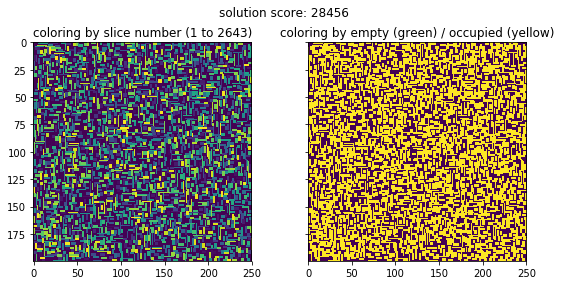

In [9]:
show_output('medium.out')

This is pretty nice. But can we do better by improving our existing solution? Yes! For instance, we can improve its performance. Although the algorithm runs in a couple of seconds for this grid size, it will be slow on the largest grid. So let's profile it to see what takes the most time.

In [10]:
%load_ext line_profiler

In [11]:
r = %lprun -r -f greedy1 greedy1('medium.in')
r.print_stats()

100%|██████████| 20000/20000 [00:15<00:00, 1326.43it/s]




score: 28376
Timer unit: 1e-06 s

Total time: 15.0029 s
File: <ipython-input-6-0cd214f13b94>
Function: greedy1 at line 47

Line #      Hits         Time  Per Hit   % Time  Line Contents
    47                                           def greedy1(fname):
    48                                               """Greedy approach to the pizza slice problem.
    49                                               We try one random shape at one random point each turn."""
    50         1      26741.0  26741.0      0.2      R, C, L, H, pizza = read_input_pizza(fname)
    51         1          2.0      2.0      0.0      possible_shapes = [(4, 2), (2, 4), (3, 3), (5, 2), (2, 5), (11, 1), (1,11), (2, 6), (6, 2), (3, 4), (4, 3)]
    52         1         71.0     71.0      0.0      slice_mask = np.zeros_like(pizza) # stores the sliced cells as 1 for easy lookup
    53         1          2.0      2.0      0.0      pizza_slices = [] # stores the slices we made
    54     20001     294721.0     14.7   

I was very surprised at this point: the function that takes the most time is the one selecting one random empty locaiton on the grid! Why is that? Well, it turns out at each iteration we are going over 200x250 = 50000 points to check whether they are zero or one. This takes a lot of time. We could do better with different data structures:

- first, a set of available locations for fast lookup
- second, a list of available locations for fast random indexing

Also:

- let's programmatically generate all possible shapes for the given grid as a function of its minimum number of ingredients and maximum slice size
- and let's loop at a given location over all of these possible slice shapes before choosing the best one

With this in mind, here's an upgraded version of the previous function.

# An upgraded version

In [12]:
import sympy
from random import shuffle

def generate_all_shapes(L, H):
    """Generates all possible tuples that satisfy the problem's shape constraints."""
    possible_shapes = []
    for size in range(2*L, H+1):
        factors = sympy.factorint(size)
        if len(factors) == 1:
            prime = list(factors.keys())[0]
            max_exp = list(factors.values())[0]
            for exp in range(0, max_exp+1):
                factor1 = prime ** exp
                factor2 = prime ** (max_exp - exp)
                possible_shapes.append((factor1, factor2))
        elif len(factors) == 2:
            prime1, prime2 = list(factors.keys())
            max_exp1, max_exp2 = list(factors.values())
            for exp1 in range(0, max_exp1+1):
                for exp2 in range(0, max_exp2+1):
                    factor1 = prime1 ** (max_exp1 - exp1) * prime2 ** (max_exp2 - exp2)
                    factor2 = prime1 ** (exp1) * prime2 ** (exp2)
                    possible_shapes.append((factor1, factor2))
        else:
            raise NotImplementedError
    return possible_shapes

def get_random_available_location_set2(random_locations, empty_cells):
    """Selects a random location that is still in empty_cells."""
    while len(random_locations) > 0:
        candidate = random_locations.pop()
        if candidate in empty_cells:
            return candidate
    else:
        return None

def update_empty_cells(location, shape, empty_cells):
    """Updates the empty cell dictionary."""
    r, c = location
    dr, dc = shape
    for rr in range(r, r+dr):
        for cc in range(c, c+dc):
            empty_cells.discard((rr, cc))
    
def greedy5(fname, iters=30000):
    """Greedy approach to pizza slicing.
    Fifth iteration: randomize the locations in which we try to add stuff."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = generate_all_shapes(L, H)
    print(f'len of generated shapes is {len(possible_shapes)}')
    slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    pizza_slices = []  # stores the slices we made
    empty_cells = set(tuple(args) for args in np.transpose(np.nonzero(1-slice_mask)).tolist())
    random_locations = list(x for x in empty_cells)
    shuffle(random_locations)
    current_score = 0
    for _ in tqdm.tqdm(range(iters)):
        location = get_random_available_location_set2(random_locations, empty_cells)
        if location is None:
            break
        selected_shapes = []
        for shape in possible_shapes:
            if satisfy_constraints(location, shape, slice_mask, pizza, L, H):
                selected_shapes.append(shape)
        if len(selected_shapes) > 0:
            current_score = score(pizza_slices)
            shape = max(selected_shapes, key=lambda shp: current_score + shp[0]*shp[1])
            cut_slice(location, shape, pizza_slices, slice_mask)
            update_empty_cells(location, shape, empty_cells)
    print('\n')
    print(f"score: {score(pizza_slices)}")
    write_output_pizza(fname.split('.')[0] + '.out', pizza_slices)

In [13]:
greedy5('medium.in')

  0%|          | 0/30000 [00:00<?, ?it/s]

len of generated shapes is 19


 51%|█████▏    | 15444/30000 [00:03<00:03, 4438.65it/s]



score: 39946


The score is better now. What does the solution look like?

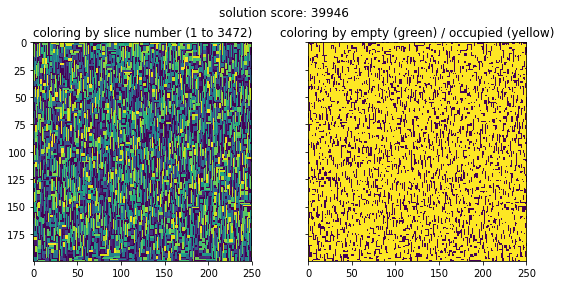

In [14]:
show_output('medium.out')

This looks a lot more compact although it's not completely yellow. Also, it runs much faster now. How much faster?

In [15]:
r = %lprun -r -f greedy5 greedy5('medium.in')
r.print_stats()

len of generated shapes is 19


 52%|█████▏    | 15472/30000 [00:10<00:10, 1446.66it/s]



score: 40185
Timer unit: 1e-06 s

Total time: 10.0926 s
File: <ipython-input-12-3bf27c5c2e47>
Function: greedy5 at line 45

Line #      Hits         Time  Per Hit   % Time  Line Contents
    45                                           def greedy5(fname, iters=30000):
    46                                               """Greedy approach to pizza slicing.
    47                                               Fifth iteration: randomize the locations in which we try to add stuff."""
    48         1      35107.0  35107.0      0.3      R, C, L, H, pizza = read_input_pizza(fname)
    49         1        264.0    264.0      0.0      possible_shapes = generate_all_shapes(L, H)
    50         1        239.0    239.0      0.0      print(f'len of generated shapes is {len(possible_shapes)}')
    51         1        292.0    292.0      0.0      slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    52         1          2.0      2.0      0.0      pizza_slices = []

# Optimization using Pythran 

As you can see in the above timing, the two most intensive functions are the `score` function and the `satisfy_constraints` function.

It turns out that with a little Pythran-fu, we can optimize these to run faster. [Pythran](http://serge-sans-paille.github.io/pythran-stories/pythran-tutorial.html) is a cool C++ compiler that knows how to handle Python and a lot of Numpy array stuff. By annotating the types we want, it can compile an optimized module from our functions.

Let's demonstrate this on the two above functions.

In [16]:
pizza_slices = [(305, 223, 7, 2), (172, 21, 14, 1), (538, 255, 14, 1), (861, 247, 7, 2), (634, 248, 2, 7), (518, 828, 14, 1)]

In [17]:
%load_ext pythran.magic

In [18]:
%%pythran
#pythran export score_pythran((int, int, int, int) list)
def score_pythran(pizza_slices):
    """Computes score of given pizza_slices list."""
    s = 0
    for pizza_slice in pizza_slices:
        s += pizza_slice[2] * pizza_slice[3]
    return s

In file included from /var/folders/r9/s1k2nd110xzfxyfym7jmyb8r0000gn/T/tmplt7qz3uu.cpp:9:
/Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/types/tuple.hpp:71:3: warning: struct template 'numpy_gexpr' was previously declared as a class template [-Wmismatched-tags]
  struct numpy_gexpr;
  ^
/Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/utils/numpy_traits.hpp:18:9: note: previous use is here
  class numpy_gexpr;
        ^
In file included from /var/folders/r9/s1k2nd110xzfxyfym7jmyb8r0000gn/T/tmplt7qz3uu.cpp:9:
/Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/types/tuple.hpp:389:3: warning: 'tuple_element' defined as a struct template here but previously declared as a class template [-Wmismatched-tags]
  struct tuple_element<I, pythonic::types::array<T, N>> {
  ^
/Library/Developer/CommandLineTools/usr/include/c++/v1/__tuple:57:34: note: did you mean struct here?
template <size_t _Ip, class _Tp> cl

In [19]:
%timeit score(pizza_slices)

1.02 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
%timeit score_pythran(pizza_slices)

683 ns ± 11.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


We can do the same for the constraints call:

In [21]:
%%pythran
#pythran export satisfy_constraints_pythran((int, int), (int, int), int[][], int[][], int, int)
def satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
    """Validates whether the given location and slice shape can be applied to the pizza."""
    r, c = location
    dr, dc = shape
    if slice_mask[r:r+dr, c:c+dc].size == dr * dc:
        if (slice_mask[r:r+dr, c:c+dc] == 0).all():
            if dr * dc <= H:
                tomatoes = pizza[r:r+dr, c:c+dc].sum()
                mushrooms = dr * dc - tomatoes
                if tomatoes >= L and mushrooms >= L:
                    return True
    return False

In file included from /var/folders/r9/s1k2nd110xzfxyfym7jmyb8r0000gn/T/tmpmej84mk_.cpp:10:
In file included from /Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/types/numpy_texpr.hpp:4:
In file included from /Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/types/ndarray.hpp:12:
In file included from /Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/utils/broadcast_copy.hpp:4:
/Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/types/tuple.hpp:71:3: warning: struct template 'numpy_gexpr' was previously declared as a class template [-Wmismatched-tags]
  struct numpy_gexpr;
  ^
/Users/kappamaki/anaconda/lib/python3.6/site-packages/pythran/pythonic/include/utils/numpy_traits.hpp:18:9: note: previous use is here
  class numpy_gexpr;
        ^
In file included from /var/folders/r9/s1k2nd110xzfxyfym7jmyb8r0000gn/T/tmpmej84mk_.cpp:10:
In file included from /Users/kappamaki/anaco

In [22]:
%timeit satisfy_constraints((3, 4), (4, 1), np.ones((R, C), dtype=np.int), np.ones((R, C), dtype=np.int), L, H)

 52%|█████▏    | 15472/30000 [00:30<00:28, 515.10it/s] 

71.3 µs ± 7.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
%timeit satisfy_constraints_pythran((3, 4), (4, 1), np.ones((R, C), dtype=np.int), np.ones((R, C), dtype=np.int), L, H)

55.6 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Equipped with this, we can now rewrite our algorithm like so:

In [24]:
def greedy5_pythran(fname, iters=30000, disable_progress_bar=False):
    """Greedy approach to pizza slicing.
    Fifth iteration: randomize the locations in which we try to add stuff."""
    R, C, L, H, pizza = read_input_pizza(fname)
    possible_shapes = generate_all_shapes(L, H)
    slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
    pizza_slices = []  # stores the slices we made
    empty_cells = set(tuple(args) for args in np.transpose(np.nonzero(1-slice_mask)).tolist())
    random_locations = list(x for x in empty_cells)
    shuffle(random_locations)
    current_score = 0
    for _ in tqdm.tqdm(range(iters), disable=disable_progress_bar):
        location = get_random_available_location_set2(random_locations, empty_cells)
        if location is None:
            break
        selected_shapes = []
        for shape in possible_shapes:
            if satisfy_constraints_pythran(location, shape, slice_mask, pizza, L, H):
                selected_shapes.append(shape)
        if len(selected_shapes) > 0:
            current_score = score_pythran(pizza_slices)
            shape = max(selected_shapes, key=lambda shp: current_score + shp[0]*shp[1])
            cut_slice(location, shape, pizza_slices, slice_mask)
            update_empty_cells(location, shape, empty_cells)
    return score(pizza_slices)

In [25]:
greedy5_pythran('medium.in')


 41%|████      | 12331/30000 [00:00<00:00, 30761.38it/s]


39888

This now runs almost instantly. Let's check the profiling again:

In [26]:
r = %lprun -r -f greedy5_pythran greedy5_pythran('medium.in', disable_progress_bar=True)
r.print_stats()

Timer unit: 1e-06 s

Total time: 1.68572 s
File: <ipython-input-24-3e117007c84a>
Function: greedy5_pythran at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def greedy5_pythran(fname, iters=30000, disable_progress_bar=False):
     2                                               """Greedy approach to pizza slicing.
     3                                               Fifth iteration: randomize the locations in which we try to add stuff."""
     4         1      23581.0  23581.0      1.4      R, C, L, H, pizza = read_input_pizza(fname)
     5         1        249.0    249.0      0.0      possible_shapes = generate_all_shapes(L, H)
     6         1        110.0    110.0      0.0      slice_mask = np.zeros_like(pizza)  # stores the sliced cells as 1 for easy lookup
     7         1          2.0      2.0      0.0      pizza_slices = []  # stores the slices we made
     8         1     109880.0 109880.0      6.5      em

Now that we have such a fast function, we can run a lot of loops and search for the best score among several iterations of our algorithm.

In [27]:
maxi = 0
for _ in tqdm.tqdm_notebook(range(100)):
    maxi = max(maxi, greedy5_pythran('medium.in', disable_progress_bar=True))
maxi

HBox(children=(IntProgress(value=0), HTML(value='')))

40264

# Conclusions

In this blog post, we went from an idea to the implementation of a fast greedy solution to the training problem of the 2018 Google Hashcode. 

Here's a high level summary of the tools that are useful when tackling such a challenge (but more broadly, when programming):

- know your data structures and their speeds: when I realized that I needed [sets](https://docs.python.org/3.6/library/stdtypes.html?highlight=set#set) (for fast membership testing) and lists (for fast lookup of index $n$) I got a 10x speedup
- use a debugger for development: during the above, the Pycharm debugger proved invaluable
- profile your functions using line_profiler and troubleshoot your hotspots
- use Jupyter Notebook for interactive exploration and plotting 
- use pythran or numba if you need to make things faster

So now that I have this fast baseline, I really need to come up with better ideas on how to cut this pizza!

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20180207_PreparingHashcode2018.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20180207_PreparingHashcode2018.ipynb).*